In [1]:
import pandas as pd
import numpy as np

# Python'a hangi dosyayı arayacağını söylüyoruz
dosya_adi = 'data_mutations.txt' 

print(f"'{dosya_adi}' dosyası yükleniyor...")
print("Eğer bir hata alırsan, dosyanın tam olarak bu kod ile AYNI KLASÖRDE olduğundan emin ol.")

try:
    # MAF dosyaları 'tab' ile ayrılır (sep='\t')
    # ve '#' ile başlayan yorum satırları içerir (comment='#')
    # Bu satır, dosyayı okuyup 'maf' adında bir tabloya dönüştürür
    maf = pd.read_csv(dosya_adi, sep='\t', comment='#')

    print("-------------------------------------------")
    print("✅ BAŞARILI! Dosya yüklendi ve analiz edildi.")
    print("-------------------------------------------")
    
    # Plandaki gibi ilk analizleri yapalım (Adım 3a)
    print(f"Toplam mutasyon sayısı: {len(maf)}")
    print(f"Benzersiz hasta sayısı: {maf['Tumor_Sample_Barcode'].nunique()}")
    print(f"Benzersiz gen sayısı: {maf['Hugo_Symbol'].nunique()}")

    # Verinin ilk 5 satırına göz atalım
    print("\n--- Verinin İlk 5 Satırı (head) ---")
    # 'maf.head()' komutu tablonun ilk 5 satırını gösterir
    print(maf.head())

except FileNotFoundError:
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    print(f"HATA: '{dosya_adi}' dosyası bulunamadı.")
    print("Lütfen dosyanın bu notebook (.ipynb) ile aynı klasörde olduğundan emin ol.")
    print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
except KeyError as e:
    print(f"HATA: '{e}' kolonu bulunamadı. Dosya formatı beklenenden farklı olabilir.")
except Exception as e:
    print(f"Beklenmedik bir hata oluştu: {e}")


'data_mutations.txt' dosyası yükleniyor...
Eğer bir hata alırsan, dosyanın tam olarak bu kod ile AYNI KLASÖRDE olduğundan emin ol.


C:\Users\yunus\AppData\Local\Temp\ipykernel_36076\308549051.py:14: DtypeWarning: Columns (38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  maf = pd.read_csv(dosya_adi, sep='\t', comment='#')


-------------------------------------------
✅ BAŞARILI! Dosya yüklendi ve analiz edildi.
-------------------------------------------
Toplam mutasyon sayısı: 243229
Benzersiz hasta sayısı: 562
Benzersiz gen sayısı: 19117

--- Verinin İlk 5 Satırı (head) ---
  Hugo_Symbol  Entrez_Gene_Id Center NCBI_Build Chromosome  Start_Position  \
0        CPN1          1369.0      .     GRCh37         10       101814119   
1       MKI67          4288.0      .     GRCh37         10       129902901   
2        NEBL         10529.0      .     GRCh37         10        21104601   
3  ANKRD30BP3        338579.0      .     GRCh37         10        45652518   
4       ERCC6          2074.0      .     GRCh37         10        50667200   

   End_Position Strand                         Consequence  \
0     101814119      +                    missense_variant   
1     129902901      +                  synonymous_variant   
2      21104606      +                    inframe_deletion   
3      45652518      +  no

In [2]:
print("Adım 3b: Sadece 6 ana gene odaklanılıyor...")

# Hedef genler (Plandaki 'actionable mutations' listesi)
target_genes = ['EGFR', 'KRAS', 'ALK', 'BRAF', 'ROS1', 'MET']

# 'maf' tablomuzdan (243,229 satır vardı) sadece 'Hugo_Symbol' kolonu 
# bu 6 genden biri olanları filtreliyoruz.
maf_filtered = maf[maf['Hugo_Symbol'].isin(target_genes)]

print("-------------------------------------------")
print(f"Toplam {len(maf)} mutasyon içinden {len(maf_filtered)} adet mutasyon bulundu.")
print("Bu 6 gen için mutasyon dağılımı:")

# Filtrelenmiş veride hangi genden kaç tane mutasyon var, sayalım:
gene_counts = maf_filtered['Hugo_Symbol'].value_counts()
print(gene_counts)

Adım 3b: Sadece 6 ana gene odaklanılıyor...
-------------------------------------------
Toplam 243229 mutasyon içinden 463 adet mutasyon bulundu.
Bu 6 gen için mutasyon dağılımı:
Hugo_Symbol
KRAS    186
EGFR     93
ALK      69
BRAF     51
ROS1     35
MET      29
Name: count, dtype: int64


In [3]:
print("Adım 3c: Mutasyon Tipleri Analizi (Varyant Sınıflandırması)")
print("----------------------------------------------------------------")
print("Bu 463 mutasyonun tiplere göre dağılımı:")
print("('Silent' gibi sessiz mutasyonları ayıklamamız gerekecek.)")
print("")

# 'maf_filtered' (463 satırlık) tablomuzdaki 'Variant_Classification' 
# (Varyant Sınıflandırması) kolonunu saydırıyoruz.
classification_counts = maf_filtered['Variant_Classification'].value_counts()

print(classification_counts)

Adım 3c: Mutasyon Tipleri Analizi (Varyant Sınıflandırması)
----------------------------------------------------------------
Bu 463 mutasyonun tiplere göre dağılımı:
('Silent' gibi sessiz mutasyonları ayıklamamız gerekecek.)

Variant_Classification
Missense_Mutation    357
Silent                37
In_Frame_Del          27
Splice_Site           13
Nonsense_Mutation     12
Frame_Shift_Del        5
In_Frame_Ins           4
3'UTR                  4
5'UTR                  2
Splice_Region          1
Intron                 1
Name: count, dtype: int64


In [4]:
print("Adım 4a: 'Anlamlı' (Actionable) Mutasyonları Filtreleme")
print("-----------------------------------------------------")
print("'Silent', 'Intron' ve 'UTR' gibi gürültü verileri ayıklıyoruz...")

# İstemediğimiz, "anlamsız" veya "sessiz" olan varyant tiplerinin listesi
variants_to_exclude = [
    'Silent', 
    '3\'UTR', 
    '5\'UTR', 
    'Intron', 
    'Splice_Region' # Splice_Site önemli, ama Splice_Region genellikle anlamsız
]

print(f"Ayıklanacak 'sessiz' ve 'anlamsız' tipler: {variants_to_exclude}")

# 'maf_filtered' (463 satırlık) tablomuzdan, 
# 'Variant_Classification' kolonu bu listede OLMAYANLARI (~) seçiyoruz.
maf_oncogenic = maf_filtered[~maf_filtered['Variant_Classification'].isin(variants_to_exclude)]

print("---")
print(f"Filtreleme öncesi mutasyon sayısı (Adım 3b): {len(maf_filtered)}")
print(f"Filtreleme sonrası 'anlamlı' mutasyon sayısı: {len(maf_oncogenic)}")
print("✅ 'maf_oncogenic' adlı nihai, temiz veri setimiz oluşturuldu.")

Adım 4a: 'Anlamlı' (Actionable) Mutasyonları Filtreleme
-----------------------------------------------------
'Silent', 'Intron' ve 'UTR' gibi gürültü verileri ayıklıyoruz...
Ayıklanacak 'sessiz' ve 'anlamsız' tipler: ['Silent', "3'UTR", "5'UTR", 'Intron', 'Splice_Region']
---
Filtreleme öncesi mutasyon sayısı (Adım 3b): 463
Filtreleme sonrası 'anlamlı' mutasyon sayısı: 418
✅ 'maf_oncogenic' adlı nihai, temiz veri setimiz oluşturuldu.


In [5]:
print("Adım 4b/5a: Görselleştirme için Veri Hazırlığı (Pivot Table)")
print("---------------------------------------------------------")
print("Veriyi 'Hasta-bazlı' formata dönüştürüyoruz (OncoPrint için hazırlık)...")

# İhtiyacımız olan 3 ana kolonu seçiyoruz
maf_pivot_data = maf_oncogenic[['Tumor_Sample_Barcode', 'Hugo_Symbol', 'Variant_Classification']]

# Veriyi pivotluyoruz:
# index = Satırlar (Hastalar)
# columns = Kolonlar (Genler)
# values = Hücrelerin değeri (Mutasyon Tipi)
# aggfunc='first' -> Bir hastanın aynı gende birden fazla mutasyonu varsa (nadir), ilkini al.
oncogenic_pivot = maf_pivot_data.pivot_table(
    index='Tumor_Sample_Barcode', 
    columns='Hugo_Symbol', 
    values='Variant_Classification', 
    aggfunc='first'
)

# Pivot sonrası oluşan 'NaN' (Not a Number) değerleri, 
# o hastada o gende mutasyon olmadığını gösterir.
# Bunları 'No Mutation' (Mutasyon Yok) olarak dolduralım.
oncogenic_pivot = oncogenic_pivot.fillna('No Mutation')

print("✅ Pivot Tablo başarıyla oluşturuldu!")
print("Bu tablo, hangi hastanın hangi geni mutasyona uğrattığını gösterir:")
print(oncogenic_pivot.head()) # .head() ile sadece ilk 5 hastayı görelim

print("\n--- Özet ---")
print(f"Pivot tablomuzun boyutu (Hasta Sayısı x Gen Sayısı): {oncogenic_pivot.shape}")

Adım 4b/5a: Görselleştirme için Veri Hazırlığı (Pivot Table)
---------------------------------------------------------
Veriyi 'Hasta-bazlı' formata dönüştürüyoruz (OncoPrint için hazırlık)...
✅ Pivot Tablo başarıyla oluşturuldu!
Bu tablo, hangi hastanın hangi geni mutasyona uğrattığını gösterir:
Hugo_Symbol                         ALK               BRAF               EGFR  \
Tumor_Sample_Barcode                                                            
TCGA-05-4244-01             No Mutation        No Mutation        No Mutation   
TCGA-05-4249-01             No Mutation  Missense_Mutation        No Mutation   
TCGA-05-4250-01             No Mutation        No Mutation        No Mutation   
TCGA-05-4382-01       Missense_Mutation  Missense_Mutation  Missense_Mutation   
TCGA-05-4389-01             No Mutation  Missense_Mutation        No Mutation   

Hugo_Symbol                        KRAS          MET               ROS1  
Tumor_Sample_Barcode                                         

Adım 5a: Mutasyon Verisinin Görselleştirilmesi (OncoPrint)
---------------------------------------------------------
Grafik oluşturuluyor... (Hasta sayısı fazlaysa bu 15-20 saniye sürebilir)


C:\Users\yunus\AppData\Local\Temp\ipykernel_36076\2194762228.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  heatmap_data = oncogenic_pivot.applymap(lambda x: color_map.get(x, -1))


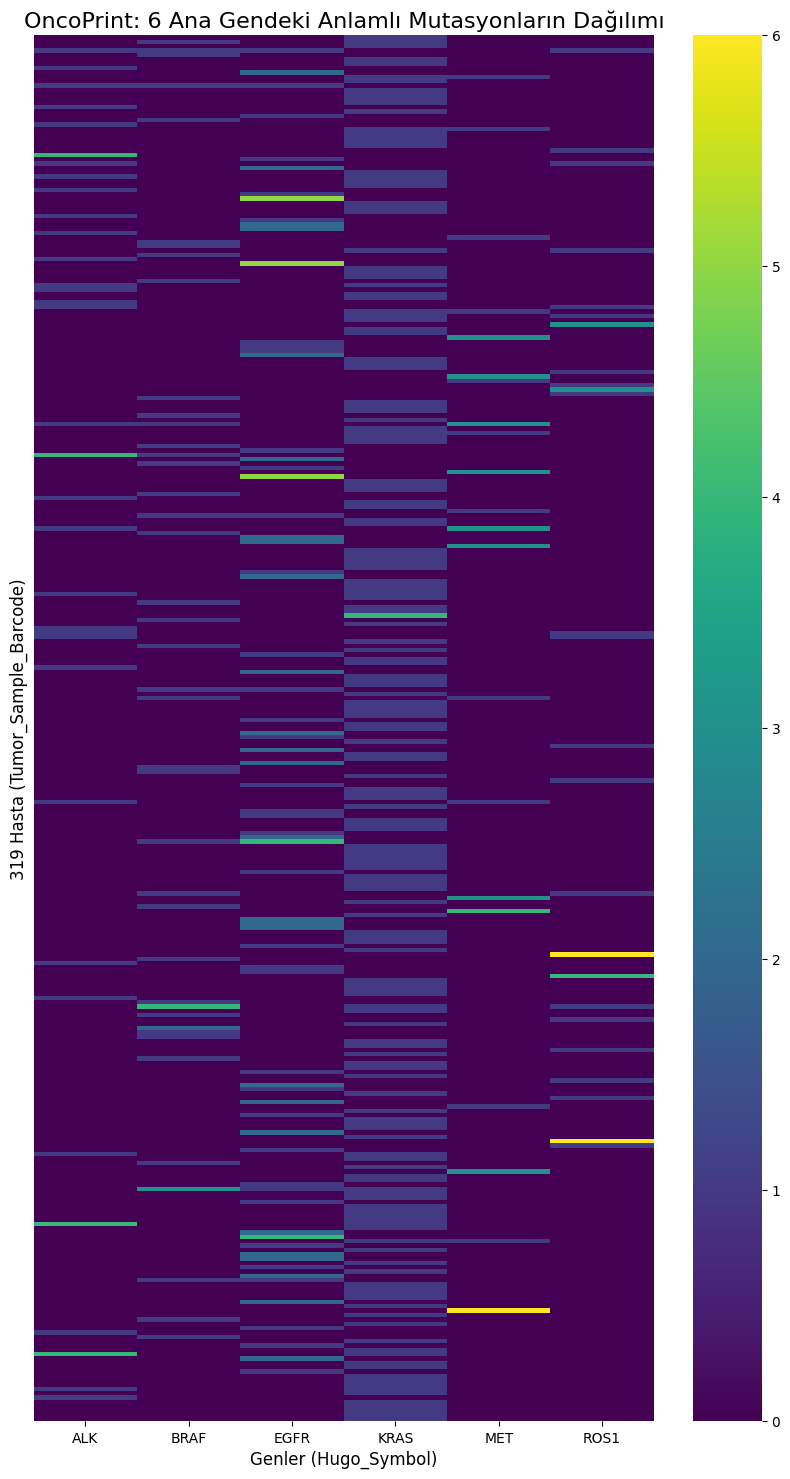

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Adım 5a: Mutasyon Verisinin Görselleştirilmesi (OncoPrint)")
print("---------------------------------------------------------")
print("Grafik oluşturuluyor... (Hasta sayısı fazlaysa bu 15-20 saniye sürebilir)")

# Şu anki tablomuzda 'Missense_Mutation', 'No Mutation' gibi metinler var.
# Seaborn'un ısı haritası çizebilmesi için bunları sayılara dönüştürmeliyiz.
# Örneğin: 'No Mutation' = 0, 'Missense' = 1, 'In_Frame_Del' = 2

# 1. Bütün mutasyon tiplerini bulalım (No Mutation hariç)
mutasyon_tipleri = maf_oncogenic['Variant_Classification'].unique()

# 2. Metinleri sayılara dönüştüren bir 'map' (harita) oluşturalım
# 'No Mutation' = 0 olacak
# Diğer her bir mutasyon tipine 1'den başlayarak numara verelim
color_map = {tip: i+1 for i, tip in enumerate(mutasyon_tipleri)}
color_map['No Mutation'] = 0

# 3. Pivot tablomuzu bu map'i kullanarak sayısal hale getirelim
heatmap_data = oncogenic_pivot.applymap(lambda x: color_map.get(x, -1))

# 4. GRAFİĞİ ÇİZME (Seaborn Heatmap)

# Grafik boyutunu ayarlayalım (Genişlik 10, Yükseklik 18)
plt.figure(figsize=(10, 18))

# Seaborn heatmap fonksiyonunu çağırıyoruz:
# cmap="viridis" -> Renk paleti (No Mutation = koyu mavi/mor, diğerleri = yeşil/sarı)
# cbar=True -> Yandaki renk skalasını göster
# yticklabels=False -> 319 hastanın ismini Y ekseninde gösterme (çok kalabalık olur)
sns.heatmap(
    heatmap_data, 
    cmap="viridis", 
    cbar=True, 
    yticklabels=False, # 319 hasta ismini gizle
    xticklabels=True  # 6 gen ismini X ekseninde göster
)

plt.title('OncoPrint: 6 Ana Gendeki Anlamlı Mutasyonların Dağılımı', fontsize=16)
plt.xlabel('Genler (Hugo_Symbol)', fontsize=12)
plt.ylabel(f'{heatmap_data.shape[0]} Hasta (Tumor_Sample_Barcode)', fontsize=12)

# Grafiği göster
plt.show()

In [7]:
import json

print("Adım 3c & 3d: Veri Temizleme ve İlaç Veritabanı ile Eşleştirme")
print("----------------------------------------------------------------")

#
# Adım 3d: İlaç veritabanını Python'da tanımlıyoruz
#
drug_database = {
    'EGFR': {
        'L858R': ['Osimertinib', 'Gefitinib', 'Erlotinib', 'Afatinib'],
        'exon19del': ['Osimertinib', 'Gefitinib', 'Erlotinib'], # Özel olarak ele alacağız
        'T790M': ['Osimertinib'],
        'G719X': ['Afatinib', 'Erlotinib']
    },
    'KRAS': {
        'G12C': ['Sotorasib', 'Adagrasib'],
        'G12D': ['Pembrolizumab (combo)']
    },
    'ALK': {
        'fusion': ['Alectinib', 'Brigatinib', 'Crizotinib'] # Özel olarak ele alacağız
    },
    'BRAF': {
        'V600E': ['Dabrafenib + Trametinib']
    },
    'ROS1': {
        'fusion': ['Entrectinib', 'Crizotinib'] # Özel olarak ele alacağız
    },
    'MET': {
        'exon14skip': ['Capmatinib', 'Tepotinib'] # Özel olarak ele alacağız
    }
}
print("✓ İlaç veritabanı (drug_database) belleğe yüklendi.")

#
# Adım 3c: Önemli kolonları seçiyoruz
# Kaynak olarak 'maf_filtered' yerine daha temiz olan 'maf_oncogenic'i kullanıyoruz.
#
important_cols = [
    'Hugo_Symbol',           # Gen adı
    'Tumor_Sample_Barcode',  # Hasta ID
    'Variant_Classification',# Mutasyon tipi (In_Frame_Del vb.)
    'HGVSp_Short',           # Protein değişimi (p.L858R)
]

maf_clean = maf_oncogenic[important_cols].copy()
print(f"✓ Önemli kolonlar seçildi. ({len(maf_clean)} adet 'anlamlı' mutasyon mevcut)")


#
# Adım 6 (Nihai Adım): Eşleştirme Fonksiyonu
#
print("\n--- Eşleştirme Başlatılıyor ---")

def find_treatment(row):
    gene = row['Hugo_Symbol']
    variant_type = row['Variant_Classification']
    # 'p.L858R' gibi verileri temizleyip 'L858R' yapıyoruz
    protein_change = str(row['HGVSp_Short']).replace('p.', '') 

    # 1. Veritabanında gen var mı?
    if gene in drug_database:
        gene_db = drug_database[gene]
        
        # 2. Direkt protein değişimi eşleşmesi (örn: L858R, G12C, V600E)
        if protein_change in gene_db:
            return (gene_db[protein_change], "Protein Match")
        
        # 3. Plandaki özel durumların eşleşmesi (Tip'e göre)
        # EGFR Exon 19 Delesyonları genellikle 'In_Frame_Del' olarak görünür
        if gene == 'EGFR' and variant_type == 'In_Frame_Del':
            return (gene_db.get('exon19del'), "Exon 19 Deletion")
        
        # ALK ve ROS1 füzyonları 'Splice_Site' veya başka türler olabilir, 
        # şimdilik 'Splice_Site'ı 'fusion' kabul edelim
        if (gene == 'ALK' or gene == 'ROS1') and (variant_type == 'Splice_Site'):
            return (gene_db.get('fusion'), "Fusion (Splice_Site)")
        
        # MET Exon 14 atlaması 'Splice_Site' veya 'Frame_Shift' olabilir
        if gene == 'MET' and (variant_type == 'Splice_Site' or 'Frame_Shift' in variant_type):
            return (gene_db.get('exon14skip'), "Exon 14 Skipping")

    return (['No Specific Treatment Found'], "No Match")

# Fonksiyonu her satıra uygulayalım ve yeni kolonlar oluşturalım
maf_clean[['Tedavi', 'Eşleşme Tipi']] = maf_clean.apply(find_treatment, axis=1, result_type='expand')


#
# Sonuçları Göster
#
print("✅ İlaç eşleştirmesi tamamlandı!")

# Sadece tedavi eşleşmesi olanları göster
matched_patients = maf_clean[maf_clean['Eşleşme Tipi'] != 'No Match']

print(f"\nToplam {len(matched_patients)} mutasyon için hedeflenebilir tedavi önerisi bulundu.")
print("--- Tedavi Eşleşme Örnekleri (İlk 20) ---")

# Sonuçları daha iyi görmek için sadece ilgili kolonları gösterelim
print(matched_patients[[
    'Tumor_Sample_Barcode', 
    'Hugo_Symbol', 
    'Variant_Classification', 
    'HGVSp_Short', 
    'Tedavi'
]].head(20))

Adım 3c & 3d: Veri Temizleme ve İlaç Veritabanı ile Eşleştirme
----------------------------------------------------------------
✓ İlaç veritabanı (drug_database) belleğe yüklendi.
✓ Önemli kolonlar seçildi. (418 adet 'anlamlı' mutasyon mevcut)

--- Eşleştirme Başlatılıyor ---
✅ İlaç eşleştirmesi tamamlandı!

Toplam 170 mutasyon için hedeflenebilir tedavi önerisi bulundu.
--- Tedavi Eşleşme Örnekleri (İlk 20) ---
      Tumor_Sample_Barcode Hugo_Symbol Variant_Classification  \
31         TCGA-05-4244-01        KRAS      Missense_Mutation   
296        TCGA-05-4249-01        KRAS      Missense_Mutation   
691        TCGA-05-4250-01        KRAS      Missense_Mutation   
8572       TCGA-05-4402-01        EGFR           In_Frame_Del   
8616       TCGA-05-4403-01        KRAS      Missense_Mutation   
8798       TCGA-05-4405-01        KRAS      Missense_Mutation   
10674      TCGA-05-4415-01        KRAS      Missense_Mutation   
10950      TCGA-05-4417-01        KRAS      Missense_Mutation   

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split

print("Hafta 2 - Adım 7: ML için Veri Hazırlama (Feature Engineering)")
print("-------------------------------------------------------------")
print("Tüm hastalar (satır) ve tüm genler (sütun) için '1' (var) / '0' (yok) matrisi oluşturuluyor...")

# Gerekli kolonları al (Hasta ID, Gen Adı)
# 243,229 mutasyonluk ana 'maf' tablomuzu kullanıyoruz
ml_data = maf[['Tumor_Sample_Barcode', 'Hugo_Symbol']]

# Bir hastada bir gende birden fazla mutasyon varsa (örn. 2 tane TP53), 
# bunu '1' olarak saymak için tekrarları (duplicates) düşüyoruz.
ml_data = ml_data.drop_duplicates()

# 'pd.crosstab' bu iş için en hızlı yöntemdir.
# Alternatif olarak 'pivot_table' da kullanılabilir.
try:
    # Satırlar = Hastalar, Sütunlar = Genler
    # Hücreler otomatik olarak '1' (varsa) veya '0' (yoksa) olacak
    ml_matrix = pd.crosstab(ml_data['Tumor_Sample_Barcode'], ml_data['Hugo_Symbol'])

    print("✅ ML Matrisi başarıyla oluşturuldu!")
    print(f"Matris boyutu (Hasta Sayısı x Toplam Gen Sayısı): {ml_matrix.shape}")
    
    # 0/1 kontrolü (bazen 1'den fazla sayabilir, emin olalım)
    ml_matrix = ml_matrix.applymap(lambda x: 1 if x > 0 else 0)

except Exception as e:
    print(f"HATA: Matris oluşturulurken bir hata oluştu: {e}")
    print("NOT: Bu işlem (crosstab) çok fazla gen varsa (19,000+) biraz hafıza (RAM) kullanabilir.")
    
# --- Adım 7b: Hedef (y) ve Özellikler (X) Tanımlama ---
# HEDEF (y): 'KRAS' geninde mutasyon var mı? (1 = Evet, 0 = Hayır)
# ÖZELLİKLER (X): 'KRAS' hariç *diğer tüm genler*

if 'KRAS' in ml_matrix.columns:
    y = ml_matrix['KRAS']
    
    # X'i tanımlarken, sadece KRAS'ı değil, 
    # Hafta 1'deki ana hedef genlerimizin tamamını çıkarmalıyız.
    # Çünkü 'EGFR' varlığı 'KRAS' yokluğunun güçlü bir göstergesidir (mutual exclusion).
    # Bunları özellik (X) olarak kullanırsak model 'hile' yapar (data leakage).
    target_genes_to_exclude = ['EGFR', 'KRAS', 'ALK', 'BRAF', 'ROS1', 'MET']
    
    # Listede olmayan (ama datada olan) genleri ayıkla
    cols_to_drop = [gen for gen in target_genes_to_exclude if gen in ml_matrix.columns]
    
    X = ml_matrix.drop(columns=cols_to_drop)
    
    print(f"\n✅ Hedef (y) tanımlandı: 'KRAS' (Toplam {y.sum()} hastada KRAS mutasyonu var)")
    print(f"✅ Özellikler (X) tanımlandı: Diğer {X.shape[1]} gen.")
    
    # --- Adım 7c: Veriyi Train/Test olarak ayırma ---
    # %80 Eğitim, %20 Test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    # stratify=y -> KRAS olan/olmayan hasta oranını train ve test setlerinde koru
    
    print("\nVeri %80 Eğitim (Train) ve %20 Test olarak ayrıldı:")
    print(f"X_train boyutu (Eğitim): {X_train.shape}")
    print(f"X_test boyutu (Test): {X_test.shape}")
    
else:
    print("\n HATA: 'KRAS' kolonu ML matrisinde bulunamadı. Kod gözden geçirilmeli.")

Hafta 2 - Adım 7: ML için Veri Hazırlama (Feature Engineering)
-------------------------------------------------------------
Tüm hastalar (satır) ve tüm genler (sütun) için '1' (var) / '0' (yok) matrisi oluşturuluyor...
✅ ML Matrisi başarıyla oluşturuldu!
Matris boyutu (Hasta Sayısı x Toplam Gen Sayısı): (562, 19117)


C:\Users\yunus\AppData\Local\Temp\ipykernel_36076\3102458753.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ml_matrix = ml_matrix.applymap(lambda x: 1 if x > 0 else 0)



✅ Hedef (y) tanımlandı: 'KRAS' (Toplam 168 hastada KRAS mutasyonu var)
✅ Özellikler (X) tanımlandı: Diğer 19111 gen.

Veri %80 Eğitim (Train) ve %20 Test olarak ayrıldı:
X_train boyutu (Eğitim): (449, 19111)
X_test boyutu (Test): (113, 19111)


Hafta 2 - Adım 8: Random Forest Modelini Eğitme ve Değerlendirme
------------------------------------------------------------------
Random Forest modeli başlatılıyor...
Model 'X_train' ve 'y_train' verileriyle eğitiliyor...
✅ Model başarıyla eğitildi.

Model test verisi (X_test) üzerinde tahmin yapıyor...
-------------------- SONUÇLAR --------------------
✅ Modelin Doğruluk (Accuracy) Oranı: 68.14%
--------------------------------------------------

Detaylı Sınıflandırma Raporu (Precision, Recall, F1-Score):
              precision    recall  f1-score   support

KRAS Yok (0)       0.70      0.96      0.81        79
KRAS Var (1)       0.25      0.03      0.05        34

    accuracy                           0.68       113
   macro avg       0.47      0.50      0.43       113
weighted avg       0.56      0.68      0.58       113


Confusion Matrix (Hata Matrisi):


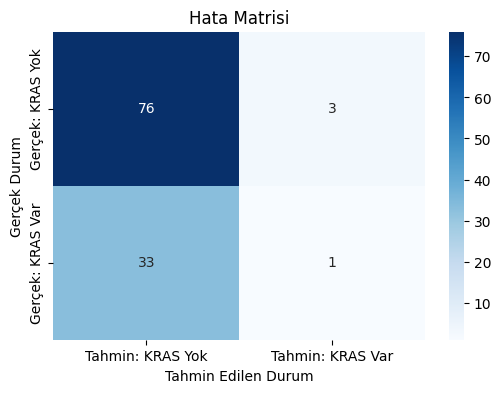

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Hafta 2 - Adım 8: Random Forest Modelini Eğitme ve Değerlendirme")
print("------------------------------------------------------------------")

#
# Adım 8a & 8b: Modeli Başlatma ve Eğitme
#
print("Random Forest modeli başlatılıyor...")
# n_estimators=100 -> 100 farklı 'karar ağacı' kullan
# random_state=42 -> Modelin her çalıştırmada aynı sonucu vermesi için
# class_weight='balanced' -> KRAS(+) (180 hasta) ve KRAS(-) (382 hasta) 
#                             arasındaki dengesizliği gidermeye yardımcı ol
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("Model 'X_train' ve 'y_train' verileriyle eğitiliyor...")
# X_train (özellikler) ve y_train (hedef) kullanarak modeli eğitiyoruz
model.fit(X_train, y_train)

print("✅ Model başarıyla eğitildi.")

#
# Adım 8c: Tahmin Yapma
#
print("\nModel test verisi (X_test) üzerinde tahmin yapıyor...")
# Eğitilen modelden, X_test verisini kullanarak 'y' (KRAS durumu) tahminlerini yapmasını istiyoruz
y_pred = model.predict(X_test)

#
# Adım 8d: Modeli Değerlendirme (Accuracy)
#
accuracy = accuracy_score(y_test, y_pred)
print("-------------------- SONUÇLAR --------------------")
print(f"✅ Modelin Doğruluk (Accuracy) Oranı: {accuracy * 100:.2f}%")
print("--------------------------------------------------")

#
# Adım 8d (Detaylı): Classification Report
#
print("\nDetaylı Sınıflandırma Raporu (Precision, Recall, F1-Score):")
# 0 = KRAS Yok, 1 = KRAS Var
print(classification_report(y_test, y_pred, target_names=['KRAS Yok (0)', 'KRAS Var (1)']))

#
# Adım 8d (Görsel): Confusion Matrix (Hata Matrisi)
#
print("\nConfusion Matrix (Hata Matrisi):")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tahmin: KRAS Yok', 'Tahmin: KRAS Var'], 
            yticklabels=['Gerçek: KRAS Yok', 'Gerçek: KRAS Var'])
plt.title('Hata Matrisi')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')
plt.show()

Hafta 2 - Adım 9: Model Yorumlama (Feature Importance)
-------------------------------------------------------
Random Forest modelinin 'en önemli' gördüğü genler analiz ediliyor...
Modelin en önemli gördüğü 'Top 20' gen:
          Gene  Importance
15932    STK11    0.003359
16493       TG    0.002570
3662     CSMD1    0.002382
11780  PCDH11X    0.002377
5757     FOLH1    0.002237
17044     TP53    0.002168
10714    NLRP5    0.001995
12469    POLA1    0.001896
18469    ZFHX4    0.001866
8964     LRRC7    0.001833
8283     KLHL1    0.001747
16224   TAS1R2    0.001697
5594    FER1L6    0.001671
12241   PKD1L2    0.001665
6981       HK3    0.001645
5361    FAM47B    0.001634
17398    TRPM8    0.001619
17385    TRPC4    0.001604
4          A2M    0.001585
9201    MAP3K4    0.001519

En önemli 20 gen için grafik oluşturuluyor...


C:\Users\yunus\AppData\Local\Temp\ipykernel_36076\3347572317.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


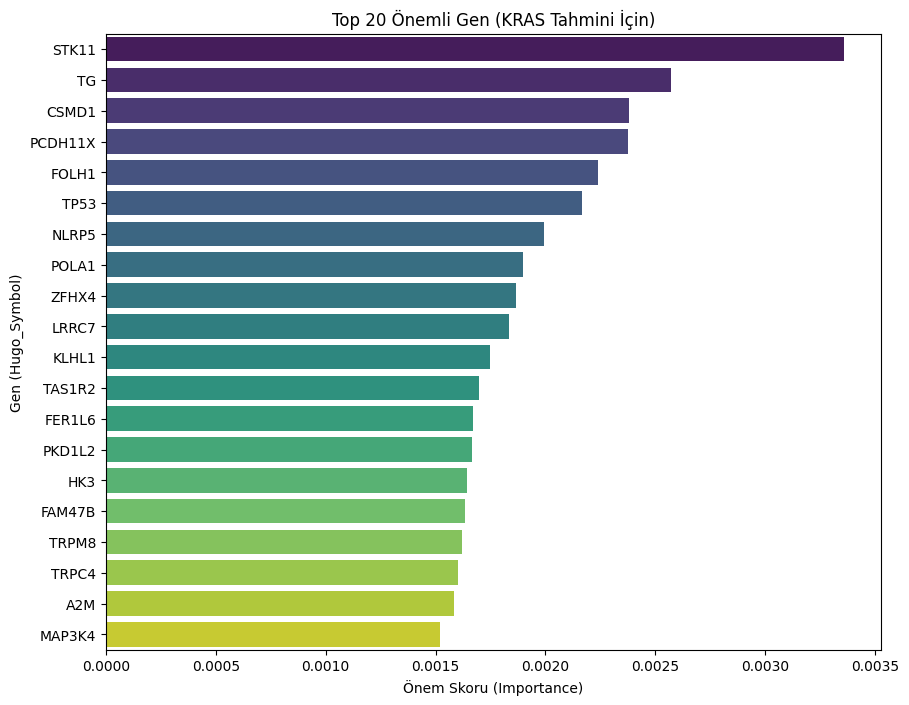

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("Hafta 2 - Adım 9: Model Yorumlama (Feature Importance)")
print("-------------------------------------------------------")
print("Random Forest modelinin 'en önemli' gördüğü genler analiz ediliyor...")

# Modelin 'feature_importances_' özelliğini alıyoruz
importances = model.feature_importances_

# Bu önem sırasını gen isimleriyle (X_train.columns) eşleştiriyoruz
feature_importance_df = pd.DataFrame({
    'Gene': X_train.columns,
    'Importance': importances
})

# En önemliden en önemsize doğru sıralıyoruz
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

#
# SONUÇLARI GÖSTER
#
print(f"Modelin en önemli gördüğü 'Top 20' gen:")
top_20_genes = feature_importance_df.head(20)
print(top_20_genes)

#
# GRAFİK (GÖRSELLEŞTİRME)
#
print("\nEn önemli 20 gen için grafik oluşturuluyor...")
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Gene', 
    data=top_20_genes, 
    palette='viridis'
)
plt.title('Top 20 Önemli Gen (KRAS Tahmini İçin)')
plt.xlabel('Önem Skoru (Importance)')
plt.ylabel('Gen (Hugo_Symbol)')
plt.show()

Hafta 2 - Adım 10: Model İyileştirme (Feature Selection)
----------------------------------------------------------
Model, sadece 'Top 20' önemli gen kullanılarak YENİDEN eğitiliyor...
Yeni Eğitim (Train) Veri Boyutu: (449, 20) (Sadece 20 gen)
Yeni Test Veri Boyutu: (113, 20) (Sadece 20 gen)

Odaklanmış model 'X_train_focused' ile eğitiliyor...
✅ Odaklanmış model başarıyla eğitildi.

Model 'X_test_focused' üzerinde tahmin yapıyor...
-------------------- İYİLEŞTİRİLMİŞ SONUÇLAR --------------------
✅ İyileştirilmiş Modelin Doğruluk (Accuracy) Oranı: 66.37%
------------------------------------------------------------------

Detaylı Sınıflandırma Raporu (İyileştirilmiş):
              precision    recall  f1-score   support

KRAS Yok (0)       0.74      0.80      0.77        79
KRAS Var (1)       0.43      0.35      0.39        34

    accuracy                           0.66       113
   macro avg       0.58      0.58      0.58       113
weighted avg       0.65      0.66      0.65       1

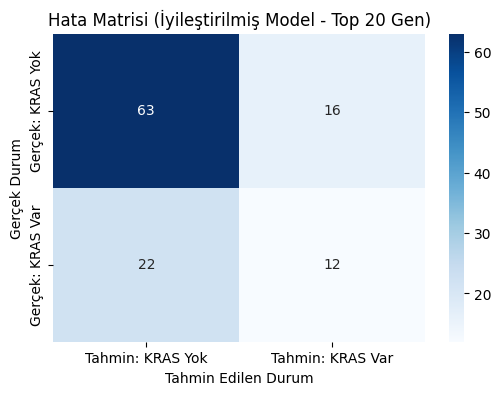

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Hafta 2 - Adım 10: Model İyileştirme (Feature Selection)")
print("----------------------------------------------------------")
print("Model, sadece 'Top 20' önemli gen kullanılarak YENİDEN eğitiliyor...")

# Adım 9'da bulduğumuz Top 20 genin listesini al
# (Eğer 'top_20_genes' değişkeni bir önceki hücrede kaldıysa)
try:
    top_20_gene_list = top_20_genes['Gene'].tolist()
except NameError:
    # Eğer bir şekilde 'top_20_genes' değişkeni kaybolduysa, manuel olarak listeyi girebiliriz
    # (Çıktıdan kopyalandı)
    top_20_gene_list = [
        'STK11', 'TG', 'CSMD1', 'PCDH11X', 'FOLH1', 'TP53', 'NLRP5', 
        'POLA1', 'ZFHX4', 'LRRC7', 'KLHL1', 'TAS1R2', 'FER1L6', 
        'PKD1L2', 'HK3', 'FAM47B', 'TRPM8', 'TRPC4', 'A2M', 'MAP3K4'
    ]
    print("NOT: 'top_20_genes' değişkeni bulunamadı, manuel liste kullanıldı.")


#
# VERİYİ YENİDEN HAZIRLA (SADECE Top 20 Gen)
#
# 19,111 sütun yerine sadece bu 20 sütunu seç
X_train_focused = X_train[top_20_gene_list]
X_test_focused = X_test[top_20_gene_list]

print(f"Yeni Eğitim (Train) Veri Boyutu: {X_train_focused.shape} (Sadece 20 gen)")
print(f"Yeni Test Veri Boyutu: {X_test_focused.shape} (Sadece 20 gen)")

#
# MODELİ YENİDEN EĞİT (Adım 8'in tekrarı)
#
model_focused = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

print("\nOdaklanmış model 'X_train_focused' ile eğitiliyor...")
model_focused.fit(X_train_focused, y_train)
print("✅ Odaklanmış model başarıyla eğitildi.")

#
# TAHMİN VE DEĞERLENDİRME (Odaklanmış model ile)
#
print("\nModel 'X_test_focused' üzerinde tahmin yapıyor...")
y_pred_focused = model_focused.predict(X_test_focused)

# SONUÇLARI GÖSTER
accuracy_focused = accuracy_score(y_test, y_pred_focused)
print("-------------------- İYİLEŞTİRİLMİŞ SONUÇLAR --------------------")
print(f"✅ İyileştirilmiş Modelin Doğruluk (Accuracy) Oranı: {accuracy_focused * 100:.2f}%")
print("------------------------------------------------------------------")

print("\nDetaylı Sınıflandırma Raporu (İyileştirilmiş):")
# 0 = KRAS Yok, 1 = KRAS Var
print(classification_report(y_test, y_pred_focused, target_names=['KRAS Yok (0)', 'KRAS Var (1)']))

print("\nConfusion Matrix (Hata Matrisi - İyileştirilmiş):")
cm_focused = confusion_matrix(y_test, y_pred_focused)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_focused, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tahmin: KRAS Yok', 'Tahmin: KRAS Var'], 
            yticklabels=['Gerçek: KRAS Yok', 'Gerçek: KRAS Var'])
plt.title('Hata Matrisi (İyileştirilmiş Model - Top 20 Gen)')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')
plt.show()

Hafta 2 - Adım 11: Model İnce Ayarı (Hyperparameter Tuning)
----------------------------------------------------------
GridSearchCV başlatılıyor...
NOT: Bu işlem 1-2 dakika sürebilir. Lütfen bekleyin...
✅ İnce Ayar (Grid Search) tamamlandı!
----------------------------------------------------------
Bulunan en iyi parametreler:
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
----------------------------------------------------------

'En İyi Model' test verisi üzerinde tahmin yapıyor...
✅ 'En İyi Model' Doğruluk (Accuracy) Oranı: 65.49%

Detaylı Sınıflandırma Raporu ('En İyi Model'):
              precision    recall  f1-score   support

KRAS Yok (0)       0.75      0.76      0.75        79
KRAS Var (1)       0.42      0.41      0.42        34

    accuracy                           0.65       113
   macro avg       0.59      0.59      0.59       113
weighted avg       0.65      0.65      0.65       113


Confusion Matrix (Hata Matrisi - 'En İyi Mod

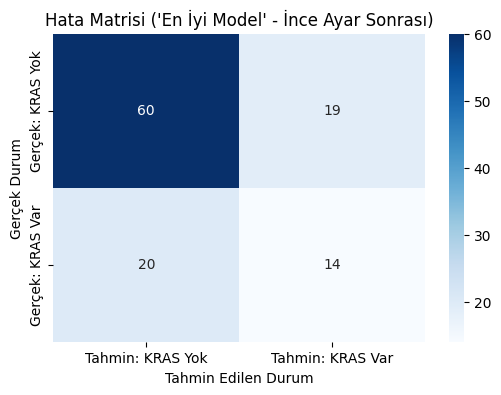

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Hafta 2 - Adım 11: Model İnce Ayarı (Hyperparameter Tuning)")
print("----------------------------------------------------------")
print("GridSearchCV başlatılıyor...")
print("NOT: Bu işlem 1-2 dakika sürebilir. Lütfen bekleyin...")

#
# 1. Denenecek Parametre Izgarasını (Grid) Tanımla
#
param_grid = {
    'n_estimators': [100, 200, 300],         # Ormandaki ağaç sayısı
    'max_depth': [10, 20, None],             # Her ağacın maksimum derinliği (None = limitsiz)
    'min_samples_leaf': [1, 2, 4],           # Bir yaprakta (kararda) olması gereken min. örneklem
    'criterion': ['gini', 'entropy']         # Karar vermek için kullanılan matematiksel fonksiyon
}

#
# 2. GridSearchCV Aracını Başlat
#
# Temel modelimiz (hala Top 20 gen verisini kullanıyoruz)
base_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# GridSearchCV'yi kur:
# estimator = base_model (kullanacağımız model)
# param_grid = param_grid (deneyeceğimiz ayarlar)
# cv=3 -> Çapraz Doğrulama (veriyi 3'e bölüp test et)
# scoring='f1_macro' -> En iyi ayarı seçerken 'f1' skoruna (recall ve precision dengesi) bak
# n_jobs=-1 -> İşlemi hızlandırmak için tüm CPU çekirdeklerini kullan
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    scoring='f1_macro', 
    cv=3, 
    n_jobs=-1 
)

#
# 3. İnce Ayarı Başlat (Fit)
#
# Bu 'fit' işlemi, X_train_focused üzerinde düzinelerce farklı model deneyecek
grid_search.fit(X_train_focused, y_train)

print("✅ İnce Ayar (Grid Search) tamamlandı!")
print("----------------------------------------------------------")
print(f"Bulunan en iyi parametreler:\n{grid_search.best_params_}")
print("----------------------------------------------------------")

#
# 4. En İyi Modeli Değerlendir
#
# En iyi ayarları bulan modeli 'best_model' olarak al
best_model = grid_search.best_estimator_

print("\n'En İyi Model' test verisi üzerinde tahmin yapıyor...")
y_pred_best = best_model.predict(X_test_focused)

# SONUÇLARI GÖSTER
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"✅ 'En İyi Model' Doğruluk (Accuracy) Oranı: {accuracy_best * 100:.2f}%")

print("\nDetaylı Sınıflandırma Raporu ('En İyi Model'):")
# 0 = KRAS Yok, 1 = KRAS Var
print(classification_report(y_test, y_pred_best, target_names=['KRAS Yok (0)', 'KRAS Var (1)']))

print("\nConfusion Matrix (Hata Matrisi - 'En İyi Model'):")
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tahmin: KRAS Yok', 'Tahmin: KRAS Var'], 
            yticklabels=['Gerçek: KRAS Yok', 'Gerçek: KRAS Var'])
plt.title("Hata Matrisi ('En İyi Model' - İnce Ayar Sonrası)")
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')
plt.show()

In [13]:
# Eğer VS Code içindeki bir hücreden çalıştırıyorsan:
!pip install xgboost

# Veya VS Code'daki terminal penceresinden çalıştırıyorsan:
# pip install xgboost

Hafta 2 - Adım 12: XGBoost Modeli ile İyileştirme
----------------------------------------------------------
XGBoost modeli 'Top 20' gen verisiyle eğitiliyor...
Sınıf ağırlığı (scale_pos_weight) ayarlandı: 2.35
Model 'X_train_focused' (Top 20 gen) ile eğitiliyor...


c:\Users\yunus\OneDrive\Masaüstü\Tasarım-Proje\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:01:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost modeli başarıyla eğitildi.

XGBoost modeli 'X_test_focused' üzerinde tahmin yapıyor...
-------------------- XGBOOST SONUÇLARI --------------------
✅ XGBoost Model Doğruluk (Accuracy) Oranı: 63.72%

Detaylı Sınıflandırma Raporu (XGBoost):
              precision    recall  f1-score   support

KRAS Yok (0)       0.75      0.72      0.74        79
KRAS Var (1)       0.41      0.44      0.42        34

    accuracy                           0.64       113
   macro avg       0.58      0.58      0.58       113
weighted avg       0.65      0.64      0.64       113


Confusion Matrix (Hata Matrisi - XGBoost):


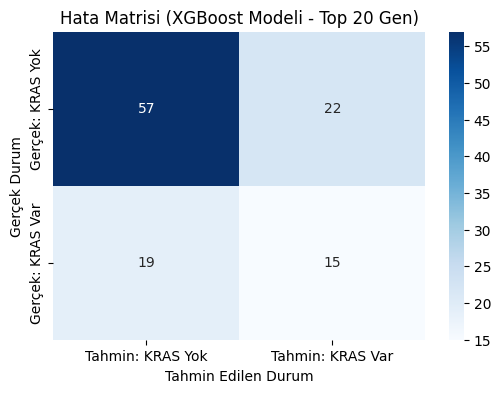

In [14]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Hafta 2 - Adım 12: XGBoost Modeli ile İyileştirme")
print("----------------------------------------------------------")
print("XGBoost modeli 'Top 20' gen verisiyle eğitiliyor...")

#
# 1. Sınıf Dengesizliği (Imbalance) Ayarı
#
# 'y_train' (eğitim verisi) içindeki '0' (KRAS Yok) ve '1' (KRAS Var) sayısını al
counts = y_train.value_counts()
# XGBoost'un 'scale_pos_weight' ayarı: (Negatif Sınıf Sayısı / Pozitif Sınıf Sayısı)
scale_pos_weight = counts[0] / counts[1]
print(f"Sınıf ağırlığı (scale_pos_weight) ayarlandı: {scale_pos_weight:.2f}")

#
# 2. XGBoost Modelini Başlatma
#
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight, # Dengesiz veriyi ele al
    n_estimators=100,                  # 100 ağaç
    max_depth=5,                       # Ağaç derinliği
    learning_rate=0.1,                 # Öğrenme oranı
    random_state=42,
    use_label_encoder=False,           # Uyumlu olması için (gereksiz uyarıyı kapatır)
    eval_metric='logloss'              # Değerlendirme metriği
)

#
# 3. Modeli Eğitme
#
print("Model 'X_train_focused' (Top 20 gen) ile eğitiliyor...")
# Not: Hâlâ Adım 10'da oluşturduğumuz 'X_train_focused' verisini kullanıyoruz
xgb_model.fit(X_train_focused, y_train)
print("✅ XGBoost modeli başarıyla eğitildi.")

#
# 4. Tahmin ve Değerlendirme
#
print("\nXGBoost modeli 'X_test_focused' üzerinde tahmin yapıyor...")
y_pred_xgb = xgb_model.predict(X_test_focused)

# SONUÇLARI GÖSTER
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("-------------------- XGBOOST SONUÇLARI --------------------")
print(f"✅ XGBoost Model Doğruluk (Accuracy) Oranı: {accuracy_xgb * 100:.2f}%")

print("\nDetaylı Sınıflandırma Raporu (XGBoost):")
# 0 = KRAS Yok, 1 = KRAS Var
print(classification_report(y_test, y_pred_xgb, target_names=['KRAS Yok (0)', 'KRAS Var (1)']))

print("\nConfusion Matrix (Hata Matrisi - XGBoost):")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Tahmin: KRAS Yok', 'Tahmin: KRAS Var'], 
            yticklabels=['Gerçek: KRAS Yok', 'Gerçek: KRAS Var'])
plt.title('Hata Matrisi (XGBoost Modeli - Top 20 Gen)')
plt.ylabel('Gerçek Durum')
plt.xlabel('Tahmin Edilen Durum')
plt.show()

In [15]:
!pip install upsetplot

Hafta 2 - Adım 13: Biyolojik Analiz (Co-Mutation)
---------------------------------------------------
KRAS, TP53 ve STK11 arasındaki 'birlikte mutasyon' ilişkisi inceleniyor...
İlişki grafiği (Upset Plot) oluşturuluyor...


c:\Users\yunus\OneDrive\Masaüstü\Tasarım-Proje\.venv\Lib\site-packages\upsetplot\data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
c:\Users\yunus\OneDrive\Masaüstü\Tasarım-Proje\.venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<Figure size 1000x600 with 0 Axes>

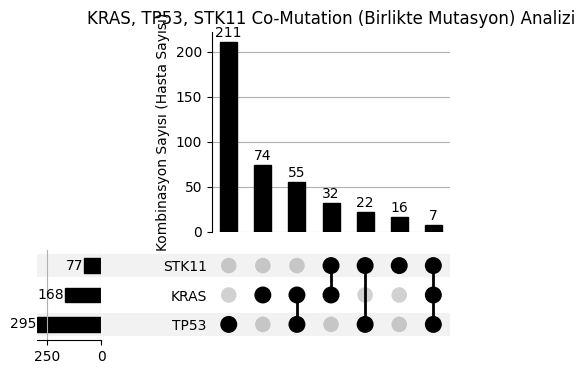


Bu 3 gen arasındaki korelasyon (ilişki) matrisi:


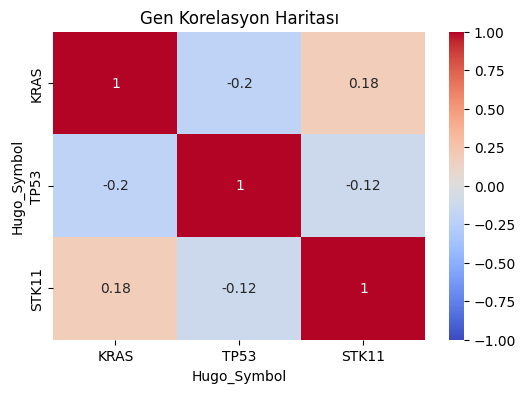

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from upsetplot import plot as upset_plot
from upsetplot import from_contents
import pandas as pd

print("Hafta 2 - Adım 13: Biyolojik Analiz (Co-Mutation)")
print("---------------------------------------------------")
print("KRAS, TP53 ve STK11 arasındaki 'birlikte mutasyon' ilişkisi inceleniyor...")

# 'ml_matrix' (Adım 7'de oluşturmuştuk) verisinden sadece bu 3 gene odaklan
# (Eğer TP53 veya STK11 yoksa, 'ml_matrix.columns' içinde olup olmadıklarını kontrol et)
co_mutation_genes = ['KRAS', 'TP53', 'STK11']

# Bu 3 genin olduğu hastaları al (1 = mutasyon var, 0 = yok)
co_mutation_data = ml_matrix[co_mutation_genes]

# 'Upset Plot' için veri formatı hazırlığı
# Bu 3 genin tüm kombinasyonlarını say
co_mutation_counts = co_mutation_data.groupby(co_mutation_genes).size().reset_index(name='count')

# 'upsetplot' kütüphanesi 'from_contents' adında özel bir format bekler
# Sadece mutasyonu olan (1) hastaları alıyoruz
data_for_upset = {}
for gene in co_mutation_genes:
    # Sadece o gende mutasyonu olan hastaların ID'lerini (index) al
    data_for_upset[gene] = co_mutation_data[co_mutation_data[gene] == 1].index

upset_data = from_contents(data_for_upset)

#
# GRAFİĞİ ÇİZ (Upset Plot)
#
print("İlişki grafiği (Upset Plot) oluşturuluyor...")
plt.figure(figsize=(10, 6))
upset_plot(upset_data, 
           sort_by='cardinality', # Önce tekli, sonra ikili, sonra üçlü mutasyonları göster
           show_counts=True)
plt.title('KRAS, TP53, STK11 Co-Mutation (Birlikte Mutasyon) Analizi')
plt.ylabel('Kombinasyon Sayısı (Hasta Sayısı)')
plt.show()

#
# KORELASYON ANALİZİ (Heatmap)
#
print("\nBu 3 gen arasındaki korelasyon (ilişki) matrisi:")
correlation_matrix = co_mutation_data.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, 
            annot=True, # Sayıları göster
            cmap='coolwarm', # Renk paleti
            vmin=-1, vmax=1) # Min/Max -1 ile +1 arası
plt.title('Gen Korelasyon Haritası')
plt.show()

In [17]:
!pip install lifelines

In [18]:
import pandas as pd
import numpy as np

print("Hafta 3 - Adım 14: Klinik Veriyi Yükleme")
print("---------------------------------------")
# Dosya adını ekran görüntünden aldık
clinical_file_name = 'data_clinical_patient.txt' 

print(f"'{clinical_file_name}' yükleniyor...")

try:
    # Klinik veriler de genellikle tab ile ayrılır (sep='\t')
    # ve yorum satırları içerir (comment='#')
    df_clinical = pd.read_csv(
        clinical_file_name,
        sep='\t',
        comment='#'
    )

    print("✅ Klinik veri başarıyla yüklendi!")
    print(f"Toplam {len(df_clinical)} hasta için klinik veri bulundu.")
    
    # Hayatta kalma analizi için hangi kolonlara sahip olduğumuzu görelim
    print("\n--- Mevcut Klinik Veri Kolonları ---")
    # Dosyadaki tüm kolonların listesini yazdıralım
    print(df_clinical.columns.to_list())

    print("\n--- Veri Önizlemesi (.head()) ---")
    print(df_clinical.head())
    
    # 'PATIENT_ID' veya 'Tumor_Sample_Barcode' gibi bir ID kolonu olup olmadığını kontrol et
    if 'PATIENT_ID' in df_clinical.columns:
        print("\nDurum: 'PATIENT_ID' kolonu bulundu. Birleştirme için kullanılabilir.")
    elif 'Tumor_Sample_Barcode' in df_clinical.columns:
        print("\nDurum: 'Tumor_Sample_Barcode' kolonu bulundu. Birleştirme için kullanılabilir.")
    else:
        print("\nUyarı: Birleştirme için 'PATIENT_ID' veya 'Tumor_Sample_Barcode' kolonu bulunamadı.")


except FileNotFoundError:
    print(f"HATA: '{clinical_file_name}' dosyası bulunamadı.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

Hafta 3 - Adım 14: Klinik Veriyi Yükleme
---------------------------------------
'data_clinical_patient.txt' yükleniyor...
✅ Klinik veri başarıyla yüklendi!
Toplam 566 hasta için klinik veri bulundu.

--- Mevcut Klinik Veri Kolonları ---
['PATIENT_ID', 'SUBTYPE', 'CANCER_TYPE_ACRONYM', 'OTHER_PATIENT_ID', 'AGE', 'SEX', 'AJCC_PATHOLOGIC_TUMOR_STAGE', 'AJCC_STAGING_EDITION', 'DAYS_LAST_FOLLOWUP', 'DAYS_TO_BIRTH', 'DAYS_TO_INITIAL_PATHOLOGIC_DIAGNOSIS', 'ETHNICITY', 'FORM_COMPLETION_DATE', 'HISTORY_NEOADJUVANT_TRTYN', 'ICD_10', 'ICD_O_3_HISTOLOGY', 'ICD_O_3_SITE', 'INFORMED_CONSENT_VERIFIED', 'NEW_TUMOR_EVENT_AFTER_INITIAL_TREATMENT', 'PATH_M_STAGE', 'PATH_N_STAGE', 'PATH_T_STAGE', 'PERSON_NEOPLASM_CANCER_STATUS', 'PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT', 'PRIOR_DX', 'RACE', 'RADIATION_THERAPY', 'WEIGHT', 'IN_PANCANPATHWAYS_FREEZE', 'OS_STATUS', 'OS_MONTHS', 'DSS_STATUS', 'DSS_MONTHS', 'DFS_STATUS', 'DFS_MONTHS', 'PFS_STATUS', 'PFS_MONTHS', 'GENETIC_ANCESTRY_LABEL']

--- Veri Önizleme

In [19]:
import pandas as pd
import numpy as np

print("Hafta 3 - Adım 15: Genetik ve Klinik Veriyi Birleştirme")
print("-----------------------------------------------------")

# 1. Klinik veriden 'survival' kolonlarını seç
# Çıktınıza göre 'OS_STATUS', 'OS_MONTHS' ve 'PATIENT_ID' kolonları var.
survival_cols = ['PATIENT_ID', 'OS_STATUS', 'OS_MONTHS']
# df_clinical, bir önceki hücrede (Adım 14) yüklendi
df_survival = df_clinical[survival_cols].copy()

# 2. 'OS_STATUS' verisini 'lifelines' için temizle (1=Öldü, 0=Yaşıyor)
# 'OS_STATUS' kolonu '1:DECEASED' veya '0:LIVING' formatındadır.
# Bize sadece '1' veya '0' lazım (ilk karakter).
df_survival['event'] = df_survival['OS_STATUS'].apply(
    lambda x: int(str(x).split(':')[0]) if pd.notna(x) else np.nan
)

# 'OS_MONTHS' kolonunu da 'duration' (süre) olarak yeniden adlandıralım
df_survival['duration'] = df_survival['OS_MONTHS']

# 3. Genetik veriyi al (Hafta 2'de oluşturulan 'ml_matrix')
# Sadece ML modelimizin önemli bulduğu 3 gene odaklanalım
genes_of_interest = ['KRAS', 'TP53', 'STK11']
# ml_matrix, Adım 7'de oluşturulmuştu
df_genetic = ml_matrix[genes_of_interest].copy()

# 4. ID'leri Eşleştirme (En Önemli Kısım)
# df_genetic index'i 'TCGA-05-4244-01' (Tumor Sample)
# df_survival 'PATIENT_ID'si 'TCGA-05-4244' (Patient)
# Genetik index'ini ilk 12 karaktere (Hasta ID'si) göre kısalt
df_genetic['PATIENT_ID'] = df_genetic.index.str[0:12]

# Aynı hastaya ait birden fazla örnek varsa (örn: -01A, -01B),
# herhangi birinde mutasyon varsa (max()) onu '1' olarak kabul et
df_genetic_grouped = df_genetic.groupby('PATIENT_ID').max() # 1 veya 0

# 5. Son Birleştirme (Merge)
# 'PATIENT_ID' üzerinden birleştir
df_merged_survival = df_survival.join(df_genetic_grouped, on='PATIENT_ID', how='inner')

# 6. Son Temizlik
# Hayatta kalma analizi için eksik (NaN) verileri at
df_merged_survival = df_merged_survival.dropna(
    subset=['duration', 'event', 'KRAS', 'TP53', 'STK11']
)
# Ayrıca, 0 ay/gün hayatta kalma bilgisi analizi bozabilir, onları da atalım
df_merged_survival = df_merged_survival[df_merged_survival['duration'] > 0]

print(f"✅ Genetik (3 gen) ve Klinik (survival) veri birleştirildi.")
print(f"Analiz için uygun {len(df_merged_survival)} hasta bulundu.")
print("\n--- Birleştirilmiş Veri Önizlemesi ---")
print(df_merged_survival[['PATIENT_ID', 'duration', 'event', 'KRAS', 'TP53', 'STK11']].head())

print("\n--- Analiz için Gruplar (Hafta 2 Bulguları Doğrulaması) ---")
#
# Sadece KRAS olanlar
kras_only_count = len(df_merged_survival[
    (df_merged_survival['KRAS'] == 1) & 
    (df_merged_survival['TP53'] == 0) & 
    (df_merged_survival['STK11'] == 0)
])
# KRAS + TP53
kras_tp53_count = len(df_merged_survival[
    (df_merged_survival['KRAS'] == 1) & 
    (df_merged_survival['TP53'] == 1)
])
# KRAS + STK11
kras_stk11_count = len(df_merged_survival[
    (df_merged_survival['KRAS'] == 1) & 
    (df_merged_survival['STK11'] == 1)
])
# KRAS olmayan (Wild Type)
kras_wt_count = len(df_merged_survival[df_merged_survival['KRAS'] == 0])

print(f"Grup 1 (Sadece KRAS): {kras_only_count} hasta")
print(f"Grup 2 (KRAS + TP53): {kras_tp53_count} hasta")
print(f"Grup 3 (KRAS + STK11): {kras_stk11_count} hasta")
print(f"Grup 4 (KRAS olmayan): {kras_wt_count} hasta")

Hafta 3 - Adım 15: Genetik ve Klinik Veriyi Birleştirme
-----------------------------------------------------
✅ Genetik (3 gen) ve Klinik (survival) veri birleştirildi.
Analiz için uygun 497 hasta bulundu.

--- Birleştirilmiş Veri Önizlemesi ---
     PATIENT_ID   duration  event  KRAS  TP53  STK11
1  TCGA-05-4249  50.070684    0.0     1     0      0
2  TCGA-05-4250   3.978039    1.0     1     0      0
3  TCGA-05-4382  19.955946    0.0     0     1      0
4  TCGA-05-4384  14.005326    0.0     0     1      0
5  TCGA-05-4389  45.007726    0.0     0     0      0

--- Analiz için Gruplar (Hafta 2 Bulguları Doğrulaması) ---
Grup 1 (Sadece KRAS): 66 hasta
Grup 2 (KRAS + TP53): 55 hasta
Grup 3 (KRAS + STK11): 38 hasta
Grup 4 (KRAS olmayan): 344 hasta


Hafta 3 - Adım 16: Hayatta Kalma Analizi (Kaplan-Meier)
-----------------------------------------------------
Grafikler ve istatistiksel testler oluşturuluyor...

Analiz için hasta grupları (karşılıklı dışlanan):
Group
1. KRAS-WT            344
2. KRAS-Only           66
3. KRAS+TP53           49
4. KRAS+STK11          32
5. KRAS+TP53+STK11      6
Name: count, dtype: int64


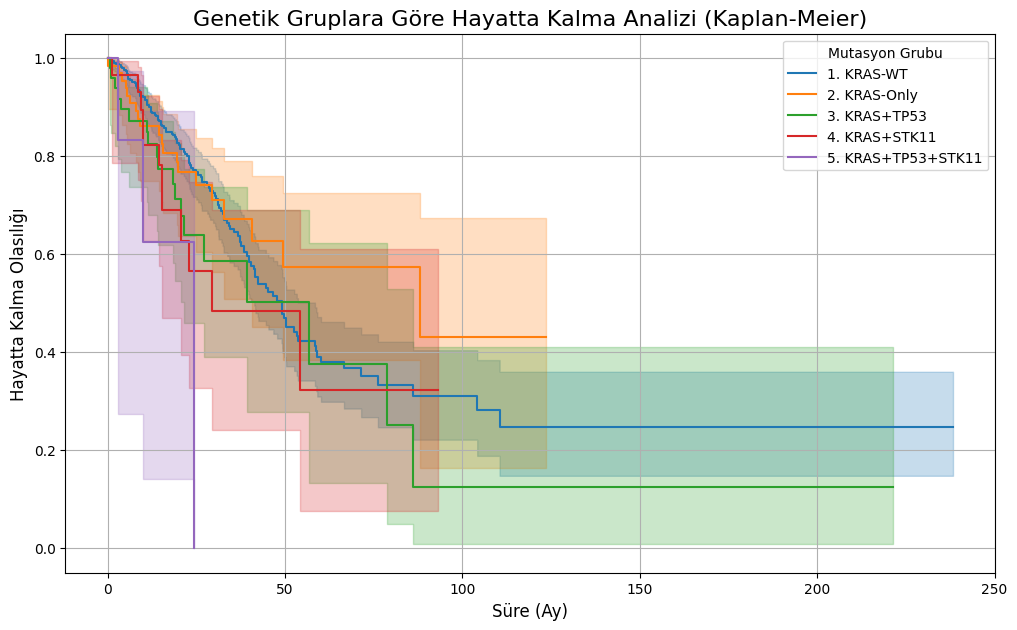


--- İstatistiksel Analiz (Log-Rank Test) ---
p-value < 0.05 ise, gruplar arasındaki fark 'anlamlıdır'.

KRAS(+) alt gruplarının karşılaştırması:
                                  test_statistic         p  -log2(p)
2. KRAS-Only  3. KRAS+TP53              2.593425  0.107308  3.220170
              4. KRAS+STK11             1.815774  0.177817  2.491534
              5. KRAS+TP53+STK11        4.147588  0.041694  4.584021
3. KRAS+TP53  4. KRAS+STK11             0.010958  0.916629  0.125590
              5. KRAS+TP53+STK11        1.350014  0.245276  2.027524
4. KRAS+STK11 5. KRAS+TP53+STK11        1.137357  0.286212  1.804846


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifelines.statistics import pairwise_logrank_test

print("Hafta 3 - Adım 16: Hayatta Kalma Analizi (Kaplan-Meier)")
print("-----------------------------------------------------")
print("Grafikler ve istatistiksel testler oluşturuluyor...")

# 'df_merged_survival' değişkeni Adım 15'ten yüklendi varsayılıyor.

#
# 1. Bilimsel olarak en doğru gruplamayı yapalım (Upset Plot mantığıyla)
#
def create_group(row):
    if row['KRAS'] == 0:
        return '1. KRAS-WT'  # KRAS olmayanlar
    
    if row['KRAS'] == 1 and row['TP53'] == 0 and row['STK11'] == 0:
        return '2. KRAS-Only' # Sadece KRAS
    
    # Birlikte mutasyon (co-mutation) grupları
    if row['KRAS'] == 1 and row['TP53'] == 1 and row['STK11'] == 0:
        return '3. KRAS+TP53'
    
    if row['KRAS'] == 1 and row['STK11'] == 1 and row['TP53'] == 0:
        return '4. KRAS+STK11'
    
    if row['KRAS'] == 1 and row['TP53'] == 1 and row['STK11'] == 1:
        return '5. KRAS+TP53+STK11'
    
    return 'Other' # (Geriye kalanlar, örn: KRAS=1 ama TP53/STK11 eksik)

# 'df_merged_survival' tablosuna 'Group' adında yeni bir kolon ekle
df_merged_survival['Group'] = df_merged_survival.apply(create_group, axis=1)

print("\nAnaliz için hasta grupları (karşılıklı dışlanan):")
print(df_merged_survival['Group'].value_counts())

#
# 2. Kaplan-Meier Grafiğini Çiz
#
kmf = KaplanMeierFitter()
plt.figure(figsize=(12, 7))

# Analiz için gereken ana değişkenler
T = df_merged_survival['duration']
E = df_merged_survival['event']
groups = df_merged_survival['Group']

# Her grup için ayrı bir eğri (curve) çizdir
for group_name in sorted(groups.unique()):
    if group_name == 'Other': # 'Other' grubunu (varsa) çizdirme
        continue
    
    mask = (groups == group_name)
    kmf.fit(T[mask], event_observed=E[mask], label=f"{group_name}")
    kmf.plot_survival_function()

plt.title('Genetik Gruplara Göre Hayatta Kalma Analizi (Kaplan-Meier)', fontsize=16)
plt.xlabel('Süre (Ay)', fontsize=12)
plt.ylabel('Hayatta Kalma Olasılığı', fontsize=12)
plt.legend(title='Mutasyon Grubu')
plt.grid(True)
plt.show()

#
# 3. İstatistiksel Analiz (Log-Rank Testi)
#
print("\n--- İstatistiksel Analiz (Log-Rank Test) ---")
print("p-value < 0.05 ise, gruplar arasındaki fark 'anlamlıdır'.")

# Sadece KRAS(+) hastaları kendi içlerinde karşılaştıralım (en ilginç olan bu)
kras_positive_df = df_merged_survival[
    (df_merged_survival['Group'] != '1. KRAS-WT') &
    (df_merged_survival['Group'] != 'Other')
]

# Gruplar arası (pairwise) istatistiksel testi çalıştır
logrank_results = pairwise_logrank_test(
    kras_positive_df['duration'], 
    kras_positive_df['Group'], 
    kras_positive_df['event']
)

print("\nKRAS(+) alt gruplarının karşılaştırması:")
print(logrank_results.summary)

In [21]:
import pandas as pd
import numpy as np

print("Hafta 4 - Adım 17: Tedavi Verisini Yükleme ve İşleme")
print("--------------------------------------------------")
treatment_file_name = 'data_timeline_treatment.txt'

try:
    df_treatment = pd.read_csv(
        treatment_file_name,
        sep='\t',
        comment='#'
    )

    print(f"✅ Tedavi verisi (ham) yüklendi. {len(df_treatment)} kayıt bulundu.")
    
    # ÖNEMLİ: 'AGENT' kolonundaki spesifik ilaçları alacağız,
    # 'Chemotherapy' gibi genel 'TREATMENT_TYPE'ları değil.
    
    # Eksik (NaN) ajanları 'Unknown' olarak doldur
    df_treatment['AGENT'].fillna('Unknown', inplace=True)
    
    # Şimdi, her hasta (PATIENT_ID) için aldığı tüm benzersiz ajanları (ilaçları) bir listeye topla
    print("Hastalar için ajanlar (ilaçlar) gruplanıyor...")
    
    # 1. Her hasta için tüm ajanları bir sete (benzersiz) topla
    df_agents_per_patient = df_treatment.groupby('PATIENT_ID')['AGENT'].apply(set)
    
    # 2. 'Unknown' ve 'nan' gibi anlamsız girdileri bu setlerden temizle
    def clean_agent_list(agent_set):
        # 'Unknown', 'nan' (string olarak) ve boş stringleri çıkar
        return [
            agent for agent in agent_set 
            if agent not in ['Unknown', 'nan', ''] and pd.notna(agent)
        ]

    df_agents_list = df_agents_per_patient.apply(clean_agent_list)
    
    # 3. Bunu bir DataFrame'e dönüştür
    df_patient_regimens = df_agents_list.reset_index()
    df_patient_regimens.columns = ['PATIENT_ID', 'TREATMENT_AGENTS']
    
    # 4. Sadece spesifik bir ilaç/ajan kaydı olan hastaları tut
    # (TREATMENT_AGENTS listesi boş olmayanları)
    df_patient_regimens = df_patient_regimens[
        df_patient_regimens['TREATMENT_AGENTS'].map(len) > 0
    ]

    print(f"\n✅ Veri işlendi. {len(df_patient_regimens)} hasta için spesifik ilaç kaydı bulundu.")
    print("--- Hasta Başına İşlenmiş İlaç Listesi (Önizleme) ---")
    
    # TCGA-05-4384 hastasının nasıl işlendiğini görelim (eğer listedeyse)
    print(df_patient_regimens.head(10))
    
    if 'TCGA-05-4384' in df_patient_regimens['PATIENT_ID'].values:
        print("\nÖrnek İşleme (TCGA-05-4384):")
        print(df_patient_regimens[
            df_patient_regimens['PATIENT_ID'] == 'TCGA-05-4384'
        ])

except FileNotFoundError:
    print(f"HATA: '{treatment_file_name}' dosyası bulunamadı.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")

Hafta 4 - Adım 17: Tedavi Verisini Yükleme ve İşleme
--------------------------------------------------
✅ Tedavi verisi (ham) yüklendi. 558 kayıt bulundu.
Hastalar için ajanlar (ilaçlar) gruplanıyor...

✅ Veri işlendi. 199 hasta için spesifik ilaç kaydı bulundu.
--- Hasta Başına İşlenmiş İlaç Listesi (Önizleme) ---
     PATIENT_ID                                   TREATMENT_AGENTS
0  TCGA-05-4382                                      [Radiation 1]
1  TCGA-05-4384  [Radiation 1, Zoledronic Acid, Vincristine, Ci...
2  TCGA-05-4390                           [Vincristine, Cisplatin]
3  TCGA-05-4398                           [Carboplatin, Etoposide]
4  TCGA-05-4402              [Carboplatin, Erlotinib, Vincristine]
5  TCGA-05-4424  [Erlotinib, Radiation 3, Radiation 2, Radiatio...
6  TCGA-05-4425                           [Vincristine, Cisplatin]
7  TCGA-05-4427                           [Vincristine, Cisplatin]
8  TCGA-05-4432                           [Vincristine, Cisplatin]
9  TCGA-05-54

C:\Users\yunus\AppData\Local\Temp\ipykernel_36076\3309143732.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_treatment['AGENT'].fillna('Unknown', inplace=True)


In [22]:
import pandas as pd
import numpy as np

print("Hafta 4 - Adım 18: Nihai Veri Birleştirme (Genetik + Klinik + Tedavi)")
print("-----------------------------------------------------------------")

try:
    # Gerekli verilerin yüklü olduğunu kontrol et
    print("Gerekli veriler kontrol ediliyor...")
    
    # Adım 15'ten (Hafta 3) - Genetik + Klinik (Survival)
    df_gc = df_merged_survival.copy()
    
    # Adım 17'den (Hafta 4) - Tedavi verileri
    df_tx = df_patient_regimens.copy()
    
    print(f"✓ Genetik + Klinik veri: {len(df_gc)} hasta")
    print(f"✓ Tedavi veri: {len(df_tx)} hasta")
    
    #
    # BİRLEŞTİRME (Inner Join - Sadece 3 veride de olan hastalar)
    #
    df_recommender_db = pd.merge(
        df_gc,
        df_tx,
        on='PATIENT_ID',
        how='inner'  # Sadece her 3 veride de olanlar
    )
    
    # 'TREATMENT_AGENTS' liste formatında, bunu 'Regimen' (tedavi rejimi) stringine çevir
    # Örnek: ['Carboplatin', 'Pemetrexed'] -> 'Carboplatin + Pemetrexed'
    df_recommender_db['REGIMEN'] = df_recommender_db['TREATMENT_AGENTS'].apply(
        lambda agents: ' + '.join(sorted(agents))
    )

    print(f"✅ Nihai birleştirme tamamlandı.")
    print(f"Öneri sistemi (Hafta 4) veritabanı için {len(df_recommender_db)} adet 'tam' hasta kaydı bulundu.")
    print("-----------------------------------------------------------------")
    
    print("\n--- Öneri Sistemi Veritabanı (Önizleme) ---")
    print(df_recommender_db[['PATIENT_ID', 'KRAS', 'TP53', 'STK11', 'REGIMEN', 'duration']].head())

    # En yaygın 10 rejimi görelim
    print("\n--- Veritabanındaki En Yaygın Tedavi Rejimleri (Top 10) ---")
    print(df_recommender_db['REGIMEN'].value_counts().head(10))

except NameError as e:
    print(f"HATA: Gerekli bir DataFrame bulunamadı: {e}")
    print("Lütfen Adım 15 (df_merged_survival) ve Adım 17 (df_patient_regimens) hücrelerini yeniden çalıştırdığınızdan emin olun.")
except Exception as e:
    print(f"Bir hata oluştu: {e}")


Hafta 4 - Adım 18: Nihai Veri Birleştirme (Genetik + Klinik + Tedavi)
-----------------------------------------------------------------
Gerekli veriler kontrol ediliyor...
✓ Genetik + Klinik veri: 497 hasta
✓ Tedavi veri: 199 hasta
✅ Nihai birleştirme tamamlandı.
Öneri sistemi (Hafta 4) veritabanı için 196 adet 'tam' hasta kaydı bulundu.
-----------------------------------------------------------------

--- Öneri Sistemi Veritabanı (Önizleme) ---
     PATIENT_ID  KRAS  TP53  STK11  \
0  TCGA-05-4382     0     1      0   
1  TCGA-05-4384     0     1      0   
2  TCGA-05-4390     1     0      0   
3  TCGA-05-4398     0     1      0   
4  TCGA-05-4402     0     1      0   

                                             REGIMEN   duration  
0                                        Radiation 1  19.955946  
1  Cisplatin + Radiation 1 + Vincristine + Zoledr...  14.005326  
2                            Cisplatin + Vincristine  37.018772  
3                            Carboplatin + Etoposide  47

In [23]:
import pandas as pd
from sklearn.neighbors import NearestNeighbors

print("Hafta 4 - Adım 19: Öneri Sistemi (K-Nearest Neighbors)")
print("-----------------------------------------------------")

# 'df_recommender_db' (Adım 18'den) yüklendi varsayılıyor.

#
# 1. Modeli Kurma
#
print("K-Nearest Neighbors (KNN) modeli kuruluyor...")

# X = Modelin "benzerlik" için bakacağı genetik profil
X_db = df_recommender_db[['KRAS', 'TP53', 'STK11']]

# n_neighbors=10 -> Yeni bir hastaya en çok benzeyen 10 komşuyu bul
# metric='hamming' -> Bu, 0/1 (var/yok) verileri için en iyi benzerlik ölçütüdür.
model_knn = NearestNeighbors(n_neighbors=10, metric='hamming')

# Modeli hastanın gen profiliyle "eğit"
model_knn.fit(X_db)

print(f"✅ Öneri modeli {len(X_db)} hastanın gen profiliyle hazırlandı.")

#
# 2. Öneri Fonksiyonunu Tanımlama
#
def recommend_treatment(new_patient_profile, k=10):
    """
    Yeni bir hastanın gen profiline göre en başarılı tedaviyi önerir.
    
    new_patient_profile: {'KRAS': 1, 'TP53': 1, 'STK11': 0} gibi bir dictionary.
    k: Benzerlik için bakılacak komşu (hasta) sayısı.
    """
    
    # Gelen profili modelin anlayacağı formata çevir
    profile_array = [list(new_patient_profile.values())]
    
    # Modeli çalıştır: Bu profile en yakın 'k' komşunun index'lerini bul
    try:
        distances, indices = model_knn.kneighbors(profile_array, n_neighbors=k)
    except ValueError:
        return "HATA: Girdi profili, modelin beklediği genlerle eşleşmiyor.", None

    # Benzer hastaların kayıtlarını çek
    neighbor_indices = indices[0]
    similar_patients_df = df_recommender_db.iloc[neighbor_indices]
    
    print(f"\n--- Analiz: {k} Benzer Hasta Bulundu ---")
    print(similar_patients_df[['PATIENT_ID', 'KRAS', 'TP53', 'STK11', 'REGIMEN', 'duration']].head())
    
    #
    # 3. En İyi Tedaviyi Analiz Et
    #
    
    # Benzer hastaların aldığı rejimleri ve yaşam sürelerini grupla
    regimen_analysis = similar_patients_df.groupby('REGIMEN')['duration'].agg(
        avg_survival_months='mean',
        patient_count='count'
    ).reset_index()
    
    # En başarılı (en yüksek ortalama yaşam süresi) olana göre sırala
    regimen_analysis = regimen_analysis.sort_values(by='avg_survival_months', ascending=False)
    
    return regimen_analysis, similar_patients_df

#
# 4. TEST: Öneri Sistemini Çalıştırma
#
print("\n--- TEST BAŞLATIYOR ---")
# 'KRAS+TP53' hastasını simüle edelim:
test_patient_1 = {
    'KRAS': 1,
    'TP53': 1,
    'STK11': 0
}

print(f"Yeni Hasta Profili (Test): {test_patient_1}")
print("Bu profile en uygun tedavi önerileri (K=20) aranıyor...")

# K=20 (20 en yakın komşu) ile öneri iste
recommendations, similar_patients = recommend_treatment(test_patient_1, k=20)

print("\n--- ÖNERİ SONUÇLARI (En Yüksek Yaşam Süresine Göre Sıralı) ---")
print(recommendations)


Hafta 4 - Adım 19: Öneri Sistemi (K-Nearest Neighbors)
-----------------------------------------------------
K-Nearest Neighbors (KNN) modeli kuruluyor...
✅ Öneri modeli 196 hastanın gen profiliyle hazırlandı.

--- TEST BAŞLATIYOR ---
Yeni Hasta Profili (Test): {'KRAS': 1, 'TP53': 1, 'STK11': 0}
Bu profile en uygun tedavi önerileri (K=20) aranıyor...

--- Analiz: 20 Benzer Hasta Bulundu ---
       PATIENT_ID  KRAS  TP53  STK11                                  REGIMEN  \
169  TCGA-95-7562     1     1      0                   Cisplatin + Pemetrexed   
113  TCGA-64-5775     1     1      0                 Carboplatin + Paclitaxel   
175  TCGA-97-7554     1     1      0                 Carboplatin + Pemetrexed   
183  TCGA-99-8025     1     1      0                              Gemcitabine   
110  TCGA-64-1677     1     1      0  Carboplatin + Gemcitabine + Radiation 1   

      duration  
169   2.860243  
113   2.038334  
175  25.479173  
183  34.848933  
110  20.646349  

--- ÖNERİ SONUÇL

c:\Users\yunus\OneDrive\Masaüstü\Tasarım-Proje\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [24]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

print("Hafta 4 (İyileştirilmiş) - Adım 18.2 & 19.2: Top 20 Gen ile Öneri Sistemi")
print("=========================================================================")

#
# 1. GEREKLİ VERİLERİ TOPLAMA
#
# Adım 7'den (Hafta 2) tam genetik matris
df_genetic_full = ml_matrix.copy()
# Adım 15'ten (Hafta 3) temizlenmiş klinik/survival verisi
df_survival_clean = df_survival.copy()
# Adım 17'den (Hafta 4) temizlenmiş tedavi verisi
df_treatment_clean = df_patient_regimens.copy()

# Adım 9'dan (Hafta 2) Top 20 gen listesi
top_20_gene_list = [
    'STK11', 'TG', 'CSMD1', 'PCDH11X', 'FOLH1', 'TP53', 'NLRP5', 
    'POLA1', 'ZFHX4', 'LRRC7', 'KLHL1', 'TAS1R2', 'FER1L6', 
    'PKD1L2', 'HK3', 'FAM47B', 'TRPM8', 'TRPC4', 'A2M', 'MAP3K4'
]
# KRAS'ı da ekleyelim
genes_to_use = ['KRAS'] + top_20_gene_list
genes_to_use = list(dict.fromkeys(genes_to_use))  # Benzersiz yap
print(f"Öneri sistemi için {len(genes_to_use)} gen kullanılacak.")

#
# 2. VERİYİ YENİDEN BİRLEŞTİRME (Top 20+ Gen ile)
#
# ID'leri eşleştir
df_genetic_full['PATIENT_ID'] = df_genetic_full.index.str[0:12]
df_genetic_full_grouped = df_genetic_full.groupby('PATIENT_ID').max()

# Sadece kullanacağımız genleri seç
df_genetic_final = df_genetic_full_grouped[genes_to_use]

# Genetik + Klinik
df_gc_merged = df_survival_clean.join(df_genetic_final, on='PATIENT_ID', how='inner')
# Genetik + Klinik + Tedavi
df_recommender_db_v2 = pd.merge(
    df_gc_merged,
    df_treatment_clean,
    on='PATIENT_ID',
    how='inner'
)

# Temizleme
df_recommender_db_v2 = df_recommender_db_v2.dropna(
    subset=['duration', 'event'] + genes_to_use
)
df_recommender_db_v2['REGIMEN'] = df_recommender_db_v2['TREATMENT_AGENTS'].apply(
    lambda agents: ' + '.join(sorted(agents))
)
print(f"✅ Top {len(genes_to_use)} Gen için {len(df_recommender_db_v2)} hasta kaydı ile yeni veritabanı hazır.")

#
# 3. YENİ MODELİ EĞİTME - UYARI SORUNU DÜZELTİLDİ
#
print("\nTop 20+ gen profiliyle yeni KNN modeli eğitiliyor...")
X_db_v2 = df_recommender_db_v2[genes_to_use].copy()

# DataFrame ile eğitiyoruz (uyarı önlenir)
model_knn_v2 = NearestNeighbors(n_neighbors=10, metric='hamming')
model_knn_v2.fit(X_db_v2)
print(f"✅ Yeni model (v2) {len(X_db_v2)} hasta ve {len(genes_to_use)} gen ile eğitildi.")

#
# 4. YENİ ÖNERİ FONKSİYONU (v2) - UYARI SORUNU DÜZELTİLDİ
#
def recommend_treatment_v2(new_patient_dict, k=10):
    """
    Top 20+ gen profili ile tedavi önerisi yapar.
    ÖNEMLİ: DataFrame kullanarak scikit-learn uyarılarını önler.
    """
    # ÖNCEKİ SORUN: Liste kullanıyorduk
    # YENİ ÇÖZÜM: DataFrame kullanıyoruz (Model DataFrame ile eğitildi)
    profile_df = pd.DataFrame([new_patient_dict], columns=genes_to_use)
    
    distances, indices = model_knn_v2.kneighbors(profile_df, n_neighbors=k)
    
    similar_patients_df = df_recommender_db_v2.iloc[indices[0]]
    
    print(f"\n--- Analiz: {k} Benzer Hasta Bulundu (v2 Modeli) ---")
    print(similar_patients_df[['PATIENT_ID'] + genes_to_use[:7] + ['REGIMEN', 'duration']].head())
    
    # Tedavi rejimlerini analiz et
    regimen_analysis = similar_patients_df.groupby('REGIMEN')['duration'].agg(
        avg_survival_months='mean',
        patient_count='count'
    ).reset_index()
    
    regimen_analysis = regimen_analysis.sort_values(by='avg_survival_months', ascending=False)
    
    # ⚠️ "Tek hastaya bakma" sorununu açıklayan bilgi
    total_patients_analyzed = regimen_analysis['patient_count'].sum()
    print(f"\n⚠️ BİLGİ: {k} benzer hastanın {len(regimen_analysis)} farklı tedavi rejimi analiz edildi.")
    print(f"Toplam {total_patients_analyzed} hasta verisi tedavi analizi için kullanıldı.")
    if total_patients_analyzed < k:
        print(f"⚠️ UYARI: {k} benzer hastadan sadece {total_patients_analyzed}'inde tedavi kaydı bulundu.")
    
    return regimen_analysis

#
# 5. TEST
#
print("\n\n--- İYİLEŞTİRİLMİŞ SİSTEM TESTİ ---")

# 21 genin tamamı için profil (diğerleri 0)
test_patient_v2 = {gene: 0 for gene in genes_to_use}
test_patient_v2['KRAS'] = 1
test_patient_v2['TP53'] = 1

print(f"Yeni Hasta Profili (21 Gen): 'KRAS+TP53' (diğerleri 0)")
print("Bu profile en uygun tedavi önerileri (K=15) aranıyor...")

recommendations_v2 = recommend_treatment_v2(test_patient_v2, k=15)

print("\n--- ÖNERİ SONUÇLARI (v2 - İyileştirilmiş) ---")
print(recommendations_v2)


Hafta 4 (İyileştirilmiş) - Adım 18.2 & 19.2: Top 20 Gen ile Öneri Sistemi
Öneri sistemi için 21 gen kullanılacak.
✅ Top 21 Gen için 196 hasta kaydı ile yeni veritabanı hazır.

Top 20+ gen profiliyle yeni KNN modeli eğitiliyor...
✅ Yeni model (v2) 196 hasta ve 21 gen ile eğitildi.


--- İYİLEŞTİRİLMİŞ SİSTEM TESTİ ---
Yeni Hasta Profili (21 Gen): 'KRAS+TP53' (diğerleri 0)
Bu profile en uygun tedavi önerileri (K=15) aranıyor...

--- Analiz: 15 Benzer Hasta Bulundu (v2 Modeli) ---
      PATIENT_ID  KRAS  STK11  TG  CSMD1  PCDH11X  FOLH1  TP53  \
24  TCGA-44-6146     1      0   0      0        0      0     0   
44  TCGA-50-5045     0      0   0      0        0      0     1   
61  TCGA-50-6673     0      0   0      0        0      0     1   
63  TCGA-50-8460     0      0   0      0        0      0     1   
54  TCGA-50-5936     1      0   0      0        0      0     0   

                                 REGIMEN   duration  
24  Carboplatin + Cisplatin + Pemetrexed  23.933984  
44          

In [25]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

print("Hafta 4 - Adım 21: 5 Farklı Hasta Profili için Öneri Sistemi Testi")
print("====================================================================")
print("NOT: Bu kod, Adım 18.2/19.2'de eğitilen 'model_knn_v2' ve 'recommend_treatment_v2' fonksiyonunun hafızada olduğunu varsayar.")

try:
    # 'genes_to_use' listesinin hafızada olduğunu kontrol et
    if 'genes_to_use' not in locals() or 'recommend_treatment_v2' not in dir():
        raise NameError("'genes_to_use' veya 'recommend_treatment_v2' bulunamadı")
    
    # --- 1. 5 FARKLI TEST PROFİLİ OLUŞTURMA ---
    
    # Temel (Wild Type) profil (tüm genler = 0)
    base_profile = {gene: 0 for gene in genes_to_use}
    
    test_profiles_list = []
    
    # Profil 1: "Sadece TP53"
    profile1 = base_profile.copy()
    profile1['TP53'] = 1
    test_profiles_list.append({"name": "Profil 1 (Sadece TP53)", "profile": profile1})
    
    # Profil 2: "Sadece KRAS"
    profile2 = base_profile.copy()
    profile2['KRAS'] = 1
    test_profiles_list.append({"name": "Profil 2 (Sadece KRAS)", "profile": profile2})

    # Profil 3: "KRAS + TP53"
    profile3 = base_profile.copy()
    profile3['KRAS'] = 1
    profile3['TP53'] = 1
    test_profiles_list.append({"name": "Profil 3 (KRAS + TP53)", "profile": profile3})

    # Profil 4: "KRAS + STK11"
    profile4 = base_profile.copy()
    profile4['KRAS'] = 1
    profile4['STK11'] = 1
    test_profiles_list.append({"name": "Profil 4 (KRAS + STK11)", "profile": profile4})

    # Profil 5: "Üçlü Mutasyon"
    profile5 = base_profile.copy()
    profile5['KRAS'] = 1
    profile5['TP53'] = 1
    profile5['STK11'] = 1
    test_profiles_list.append({"name": "Profil 5 (KRAS + TP53 + STK11)", "profile": profile5})

    k_neighbors = 10
    
    # --- 2. 5 PROFİLİ DÖNGÜDE TEST ETME ---
    
    for item in test_profiles_list:
        profile_name = item['name']
        new_patient_profile = item['profile']
        
        # Sadece mutasyonlu genleri gösteren özet
        profile_summary = {gene: val for gene, val in new_patient_profile.items() if val == 1}
        if not profile_summary:
            profile_summary = "Tamamen Temiz (WT)"
        
        print(f"\n\n--- TEST BAŞLATIYOR: {profile_name} ---")
        print(f"Yeni Hasta Profili (Özet): {profile_summary}")
        print(f"Bu profile en uygun tedavi önerileri (K={k_neighbors}) aranıyor...")
        
        # recommend_treatment_v2 fonksiyonunu çağır
        recommendations_v2 = recommend_treatment_v2(new_patient_profile, k=k_neighbors)
        
        if recommendations_v2 is not None and not recommendations_v2.empty:
            print(f"\n--- ÖNERİ SONUÇLARI ({profile_name}) ---")
            print(recommendations_v2)
            
            # En iyi tavsiyeyi seç
            en_iyi_tavsiye = recommendations_v2.iloc[0]
            print("\n--- SONUÇ (ÖZET) ---")
            print(f"Bu gen profiline sahip hastalarda (n={int(en_iyi_tavsiye['patient_count'])}),")
            print(f"'{en_iyi_tavsiye['REGIMEN']}' tedavisi,")
            print(f"ortalama {en_iyi_tavsiye['avg_survival_months']:.2f} ay yaşam süresi ile en başarılı sonuç olarak görünmektedir.")
        else:
            print(f"\nUyarı: {profile_name} için tedavi bilgisi olan yeterli hasta veritabanında bulunamadı.")
        
        print("=" * 70)

    print("\n\n✅ Tüm 5 test profili için öneri analizleri tamamlandı.")

except NameError as e:
    print(f"\n! HATA: Gerekli bir fonksiyon/değişken bulunamadı: {e}")
    print("Lütfen önce Adım 18.2/19.2 (İyileştirilmiş Öneri Sistemi) hücresini çalıştırın.")
except Exception as e:
    print(f"\nBir hata oluştu: {e}")


Hafta 4 - Adım 21: 5 Farklı Hasta Profili için Öneri Sistemi Testi
NOT: Bu kod, Adım 18.2/19.2'de eğitilen 'model_knn_v2' ve 'recommend_treatment_v2' fonksiyonunun hafızada olduğunu varsayar.


--- TEST BAŞLATIYOR: Profil 1 (Sadece TP53) ---
Yeni Hasta Profili (Özet): {'TP53': 1}
Bu profile en uygun tedavi önerileri (K=10) aranıyor...

--- Analiz: 10 Benzer Hasta Bulundu (v2 Modeli) ---
       PATIENT_ID  KRAS  STK11  TG  CSMD1  PCDH11X  FOLH1  TP53  \
61   TCGA-50-6673     0      0   0      0        0      0     1   
63   TCGA-50-8460     0      0   0      0        0      0     1   
44   TCGA-50-5045     0      0   0      0        0      0     1   
35   TCGA-49-4490     0      0   0      0        0      0     1   
108  TCGA-62-A46Y     0      0   0      0        0      0     1   

                                   REGIMEN   duration  
61                             Radiation 1   0.723280  
63                             Radiation 1  27.254496  
44                             Radiatio